In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((210, 90, 60), input="husl", n_colors=50))
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=50))
my_cmap = ListedColormap(sns.color_palette("RdBu_r", 50))
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

# from matplotlib.colors import to_rgb, to_rgba

# def scatter(x, y, color, alpha_arr, **kwarg):
#     r, g, b = to_rgb(color)
#     # r, g, b, _ = to_rgba(color)
#     color = [(r, g, b, alpha) for alpha in alpha_arr]
#     plt.scatter(x, y, c=color, **kwarg)

In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F

from torch import distributions
from torch import nn
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
import sys
sys.path.append('../')
from core import networks
from core import toy_data
from core import models

In [4]:
def sample_data(name, batch_size):
    x = toy_data.inf_train_gen(name, batch_size=batch_size)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

def plot_samples(samples):
    _ = plt.hist2d(samples.detach().cpu().numpy()[:,0], 
                   samples.detach().cpu().numpy()[:,1], 
                   bins=50, cmap=my_cmap)
    
@torch.no_grad()
def plot_ebm_density(ebm):
    x = torch.linspace(-3.5,3.5,100)
    y = torch.linspace(-3.5,3.5,100)
    x_grid,y_grid = torch.meshgrid(x,y)
    pdf = torch.exp(-ebm(torch.stack([x_grid, y_grid], axis=2).reshape([-1, 2]))).detach()
    pdf = pdf.numpy().reshape([100, 100])
    plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
    
def plot_training_process(method_name, data_name):
    log = pd.read_csv('../logs/%s_%s.csv' % (method_name, data_name))

    fs = 15
    figsize(16,5)
    plt.subplot(131)
    plt.plot(log['loss'])
    plt.ylabel('loss', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.grid()
    plt.subplot(132)
    plt.plot(log['mmd'])
    plt.ylabel('MMD', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.grid()
    plt.subplot(133)
    plt.plot(log['logl'])
    plt.ylabel('logl', fontsize=fs)
    plt.xlabel('iter', fontsize=fs)
    plt.grid()
    
def plot_final_model(method_name, data_name, use_base=True):
    net = networks.SmallMLP(2)
    base_dist = distributions.Normal(torch.zeros(2), torch.ones(2))
    ebm = models.EBM(net, base_dist if use_base else None).cpu()
    ebm.load_state_dict(torch.load('../checkpoints/%s_%s' % (method_name, data_name), map_location=device))

    particles = torch.load('../checkpoints/particles_%s_%s' % (method_name, data_name), map_location=device)
    train_data = sample_data(data_name, 1000)
    
    figsize(16,5)
    plt.subplot(131)
    plot_samples(train_data)
    plt.subplot(132)
    plot_samples(particles)
    plt.subplot(133)
    plot_ebm_density(ebm)

In [5]:
device = torch.device('cpu')

## Alpha

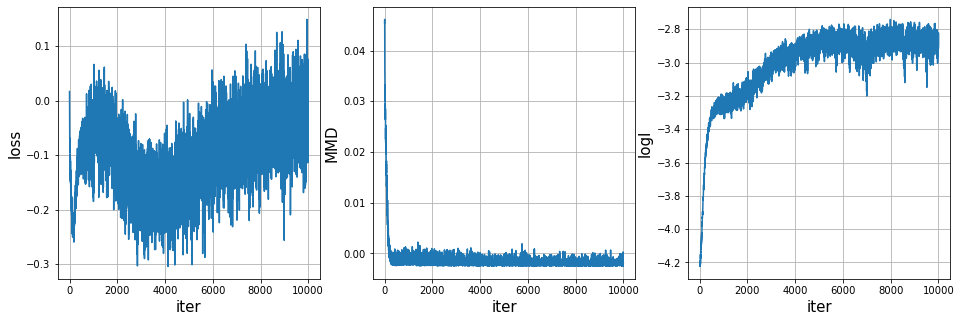

In [59]:
plot_training_process('alpha', '8gaussians')

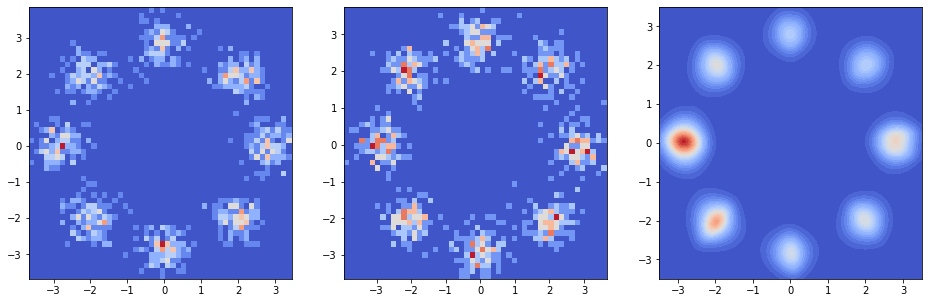

In [60]:
plot_final_model('alpha', '8gaussians')

## Beta

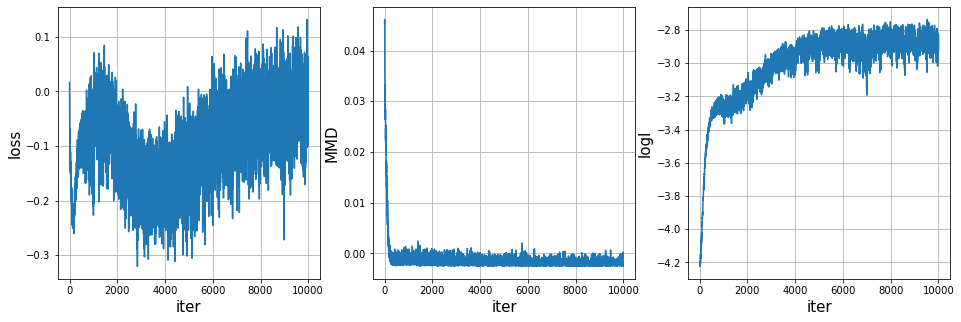

In [6]:
plot_training_process('beta', '8gaussians')

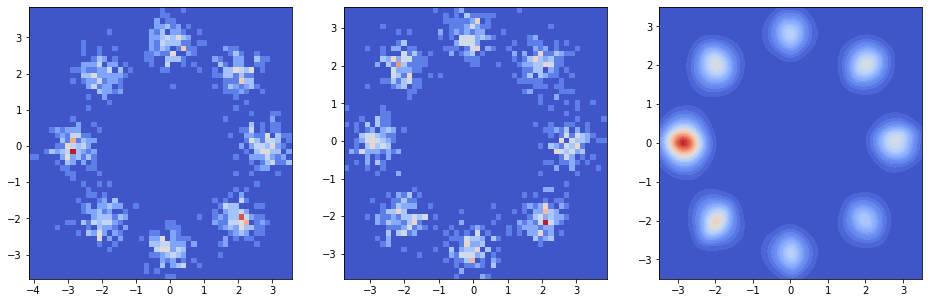

In [7]:
plot_final_model('beta', '8gaussians')

## Zero

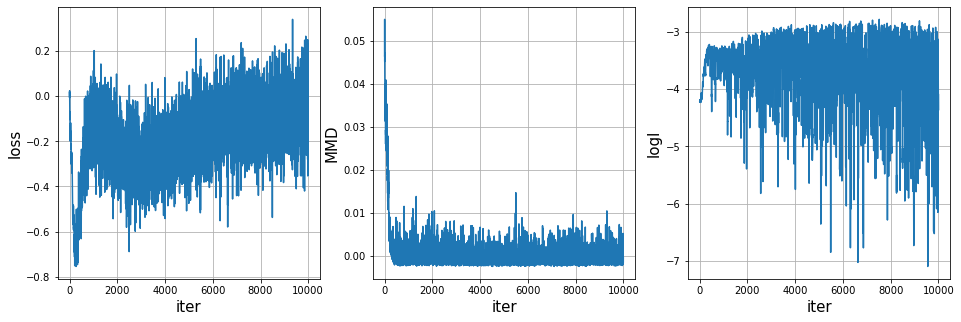

In [8]:
plot_training_process('zero', '8gaussians')

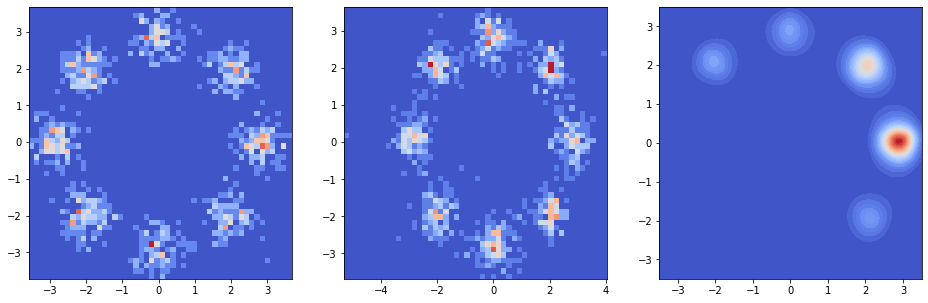

In [9]:
plot_final_model('zero', '8gaussians')

## Gamma

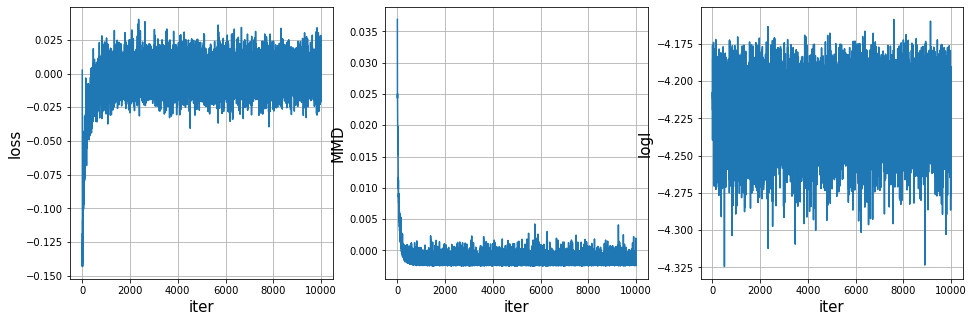

In [123]:
plot_training_process('gamma', '8gaussians')

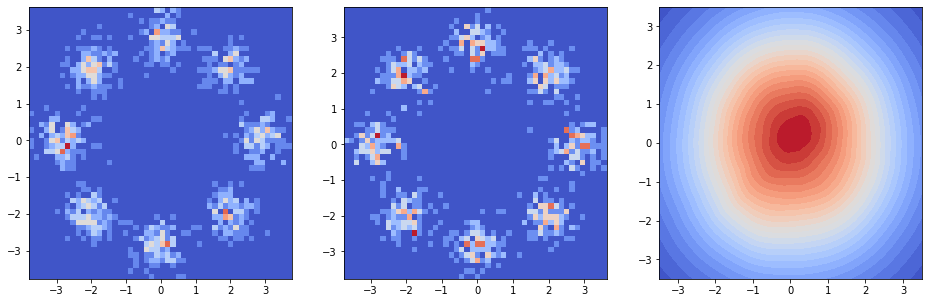

In [7]:
plot_final_model('gamma', '8gaussians', True)

## Delta

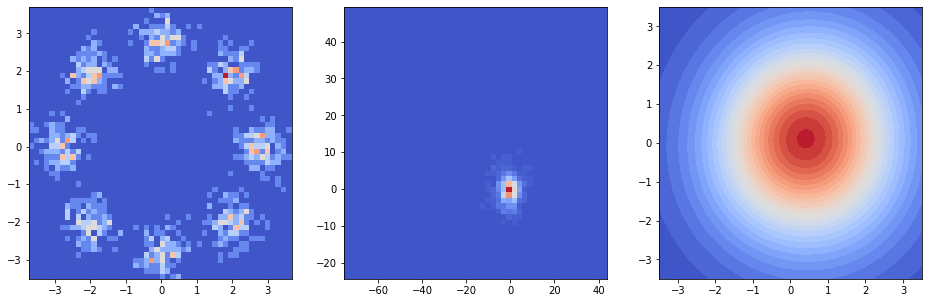

In [9]:
plot_final_model('delta', '8gaussians', True)

In [8]:
net = networks.SmallMLP(2)
base_dist = distributions.Normal(torch.zeros(2), torch.ones(2))
ebm = models.EBM(net, base_dist)

In [22]:
for p in ebm.parameters():
    print(p.grad)

tensor([-45.9165, -16.0042])
tensor([-3086.5034, -3170.3936])
tensor([[-8.4101e-01, -1.2307e+01],
        [ 4.3647e+00, -4.6565e+00],
        [-1.9182e+00, -1.3574e+01],
        [ 1.2409e+01,  2.1991e-02],
        [-1.9579e+01,  6.9082e-01],
        [-4.7153e+00, -1.4915e+01],
        [ 5.1805e-02, -1.5866e-01],
        [ 7.1306e+00, -8.4676e+00],
        [-3.4230e+00, -1.1106e+00],
        [ 7.4190e+00,  6.8829e+00],
        [ 2.3850e-01, -3.4462e-02],
        [ 4.5914e+00, -6.7104e-01],
        [ 1.1728e+01, -6.6259e+00],
        [ 3.1371e+00,  4.1984e-01],
        [-5.5771e+00,  4.7382e+00],
        [-3.0639e+00,  1.8373e+00],
        [ 2.8584e+00, -1.2171e+01],
        [ 6.8741e+00, -6.0393e+00],
        [ 6.8808e+00, -2.6504e+00],
        [-5.5240e+00,  5.4432e+00],
        [ 1.8372e+01,  1.2269e+01],
        [-4.4358e+00, -9.8833e-02],
        [ 2.4257e+00, -9.5267e+00],
        [-4.5545e-01, -1.1829e+00],
        [-6.9914e+00,  5.1165e+00],
        [-7.0737e+00, -8.9055e+00],
  

In [12]:
ebm_copy = deepcopy(ebm)

In [21]:
for p in ebm_copy.parameters():
    print(p.grad)

None
None
None
None
None
None
None
None


In [20]:
train_data = sample_data('8gaussians', 1000)
loss = ebm(train_data).sum()
loss.backward()

In [ ]:
ebm(particels)